# Problema de transporte discreto

Dadas dos distribuciones de probabilidad discretas:

* $X$: con soporte $x_1<x_2<\ldots<x_m$ con probabilidades $P(X=x_i) = p_i$.
* $Y$: con soporte $y_1<y_2<\ldots<y_n$ con probabilidades $P(Y=y_j) = q_j$.

Queremos hallar una distribución conjunta $A=(a_{ij}) \geqslant 0$ tal que:

$$\min_{a_{ij}} \sum_{i,j} a_{ij} |x_i-y_j|$$

sujeto a:

$$\sum_j a_{ij} = p_i \quad \forall i=1,\ldots,m,$$

$$\sum_i a_{ij} = q_j \quad \forall j=1,\ldots,n.$$

In [31]:
## Para instalar los paquetes del Project.toml la primera vez
#using Pkg; Pkg.instantiate()
#Pkg.add("VoronoiCells")
#import Pkg; Pkg.add("GeometryBasics")

   Resolving package versions...
    Updating `~/Documents/transport_problems/Project.toml`
  [5c1252a2] + GeometryBasics v0.3.13
  No Changes to `~/Documents/transport_problems/Manifest.toml`


In [3]:
using Pkg
Pkg.rm("VoronoiCells")
Pkg.add(Pkg.PackageSpec(;name="VoronoiCells", version="0.2.2"))

    Updating `~/Documents/transport_problems/Project.toml`
  [e3e34ffb] - VoronoiCells v0.3.0
    Updating `~/Documents/transport_problems/Manifest.toml`
  [fd0ad045] - GeometricalPredicates v0.4.1
  [e3e34ffb] - VoronoiCells v0.3.0
  [72f80fcb] - VoronoiDelaunay v0.4.1
   Resolving package versions...
    Updating `~/Documents/transport_problems/Project.toml`
  [e3e34ffb] + VoronoiCells v0.2.2
    Updating `~/Documents/transport_problems/Manifest.toml`
  [fd0ad045] + GeometricalPredicates v0.4.1
  [5c1252a2] ↓ GeometryBasics v0.4.2 ⇒ v0.3.13
  [e3e34ffb] + VoronoiCells v0.2.2
  [72f80fcb] + VoronoiDelaunay v0.4.1


In [4]:
using JuMP, GLPK, Ipopt

#m=3
x=[1.0;2.0;3.0]
p=[0.2;0.4;0.4]

#n=2
y=[0;4.0]
q=[0.5;0.5]

#model = JuMP.Model(GLPK.Optimizer)
model = JuMP.Model(Ipopt.Optimizer)


m=length(x)
n=length(y)

#Calculo los pesos |xi-yj|
W=abs.(x*ones(1,n) - ones(m,1)*y')

@variable(model,A[1:m,1:n]>=0)

conp = @constraint(model, sum(A, dims=2).==p)
conq = @constraint(model, sum(A, dims=1).==q')

@objective(model,Min, sum( A.*W ))

model

A JuMP Model
Minimization problem with:
Variables: 6
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 5 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 6 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt
Names registered in the model: A

In [5]:
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality co

In [6]:
objective_value(model)

1.3999999616644336

In [7]:
#Extraigo el valor optimo
value.(A)

3×2 Matrix{Float64}:
  0.2         -9.54545e-9
  0.3          0.1
 -9.54545e-9   0.4

In [8]:
#Extraigo los multiplicadores de p
lambda = dual.(conp)

3×1 Matrix{Float64}:
 1.7120871502758715e18
 1.7120871502758715e18
 1.7120871502758715e18

In [9]:
#Extraigo los multiplicadores de q
mu = dual.(conq)

1×2 Matrix{Float64}:
 -1.71209e18  -1.71209e18

In [10]:
W

3×2 Matrix{Float64}:
 1.0  3.0
 2.0  2.0
 3.0  1.0

In [11]:
lambda * ones(1,n) + ones(m,1)*mu

3×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0

# Problema de transporte discreto - Cantidad de destinos variable

Dadas dos distribuciones de probabilidad discretas:

* $X$: con soporte $x_1<x_2<\ldots<x_m$ con probabilidades $P(X=x_i) = p_i$.
* $Y$: con soporte $y_1<y_2<\ldots<y_n$ con probabilidades $P(Y=y_j) = q_j$.

Queremos hallar una distribución conjunta $A=(a_{ij}) \geqslant 0$ tal que:

$$\min_{a_{ij}} \sum_{i,j} a_{ij} |x_i-y_j| + \epsilon \sum_{j} \phi(q_{j})$$

sujeto a:

$$\sum_j a_{ij} = p_i \quad \forall i=1,\ldots,m,$$

$$\sum_i a_{ij} = q_j \quad (VAR).$$

## Caso 1: 

Consideramos $\phi(x) = \frac{x^{2}}{2}$

In [12]:
using JuMP, GLPK, Ipopt
#revisar paquete distances.JL

#m=3
x=10*rand(10) #[1.0;2.0;3.0;4;5;6;7;8;9;10] #--> Trabajar con elementos de R^2
p=ones(10)

#n=2
y=[0;7;15]

#epsilon
eps = 0 #¿Qué pongo?

model = JuMP.Model(GLPK.Optimizer)
#model = JuMP.Model(Ipopt.Optimizer)


m=length(x)
n=length(y)

#Calculo los pesos |xi-yj|
W=abs.(x*ones(1,n) - ones(m,1)*y')

@variable(model,A[1:m,1:n]>=0)
@variable(model,q[1:n])

conp = @constraint(model, sum(A, dims=2).==p)
conq = @constraint(model, sum(A, dims=1).==q')

@objective(model,Min, sum( A.*W ))# + eps/2 * (q'*q) )

model

A JuMP Model
Minimization problem with:
Variables: 33
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 13 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 30 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: A, q

In [13]:
optimize!(model)

In [14]:
objective_value(model)

14.759064870391066

In [15]:
#Extraigo el valor optimo
value.(A)

10×3 Matrix{Float64}:
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0

In [16]:
value.(q)

3-element Vector{Float64}:
 3.0
 7.0
 0.0

In [17]:
#Extraigo los multiplicadores de p
lambda = dual.(conp)

10×1 Matrix{Float64}:
 1.1962021236634577
 0.1455424803138099
 1.5496907727236362
 1.144115671884121
 1.8353264241893976
 1.5261952846449045
 1.6360296084148862
 3.170855435966028
 0.42630442279006076
 2.1288026458007625

In [18]:
#hacerlo en R^2,dentro de un cuadrado de 0,0 a 1,1
#plotear con el comando scatter los x, con diferentes colores los que tienen el 1 en la primer columna, los que tienen el 1 en la segunda col, etc.
#manera más sencilla con marker.z
#spliteo el X y corro la optimización, voy cambiando los cargadores
#

## Caso 2: Trabajando en $R^{2}$

Consideramos $\phi(x) = \frac{x^{2}}{2}$

In [19]:
#m=los que quiera
m = 100
x = sortslices(rand(m,2), dims = 1);
p = 2*rand(m)#ones(m);

#n=4
#y=[[1/3 1/3]; [1/3 2/3]; [2/3 1/3]; [2/3 2/3]];
#y=[[1/3 1/3]; [2/3 2/3]];
y = sortslices(rand(6,2), dims = 1);
y = vcat(y, [2 0.5])
n=size(y)[1];

In [22]:
using JuMP, GLPK, Ipopt
#revisar paquete distances.JL

#epsilon
eps = 0.01 #200

#model = JuMP.Model(GLPK.Optimizer)
model = JuMP.Model(Ipopt.Optimizer)

#Calculo los pesos |xi-yj|
w1 = (x[:,1]*ones(1,n) - ones(m,1)*y[:,1]').^2
w2 = (x[:,2]*ones(1,n) - ones(m,1)*y[:,2]').^2
W=(w1+w2).^(1/2)

@variable(model,A[1:m,1:n]>=0)
#@variable(model,q[1:n])
@variable(model,q[1:n-1]<=(m/(n-1)*1.4)) # carga máxima por auto con tolerancia, ojo con n
@variable(model,q[n]) #ultimo cargador sin límite

conp = @constraint(model, sum(A, dims=2).==p)
conq = @constraint(model, sum(A, dims=1).==q')

@objective(model,Min, sum( A.*W ) + eps/2 * (q'*q) )
#@objective(model,Min, sum( A.*W ))

model

LoadError: An object of name q is already attached to this model. If this
    is intended, consider using the anonymous construction syntax, e.g.,
    `x = @variable(model, [1:N], ...)` where the name of the object does
    not appear inside the macro.

    Alternatively, use `unregister(model, :q)` to first unregister
    the existing name from the model. Note that this will not delete the
    object; it will just remove the reference at `model[:q]`.


In [23]:
optimize!(model);

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      706
                     variables with only lower bounds:      700
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        6
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [24]:
objective_value(model)

0.0

In [25]:
#Extraigo el valor optimo
value.(A)

100×7 Matrix{Float64}:
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 ⋮                                            ⋮        
 3.78079  3.78079  3.78079  3.78079  3.78079  3.78079  3.78079
 3.78079  3.78079  3.78079  3.78079  3.

In [26]:
round.(value.(A), digits=3)

100×7 Matrix{Float64}:
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 ⋮                                  ⋮      
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3.781  3.781  3.781  3.781  3.781  3.781  3.781
 3

In [27]:
value.(q)

6-element Vector{Float64}:
 -3.769911000515064
 -3.769911000515064
 -3.769911000515064
 -3.769911000515064
 -3.769911000515064
 -3.769911000515064

In [28]:
#Extraigo los multiplicadores de p
lambda = dual.(conp);

In [29]:
#Redondea los valores de A para que sean 0 o 1 (Probar)
Ar = round.(value.(A));
Ao = value.(A);

#Separa los puntos por destino (buscando 1s)
#X = [x[findall(x->x==1, Ar[:,i]),1] for i in 1:n];
#Y = [x[findall(x->x==1, Ar[:,i]),2] for i in 1:n];

#Separa los puntos por destino (buscando maximos)
maximos = [argmax(Ao[i,:]) for i in 1:m];
X = [x[findall(x->x==i, maximos),1] for i in 1:n];
Y = [x[findall(x->x==i, maximos),2] for i in 1:n];

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


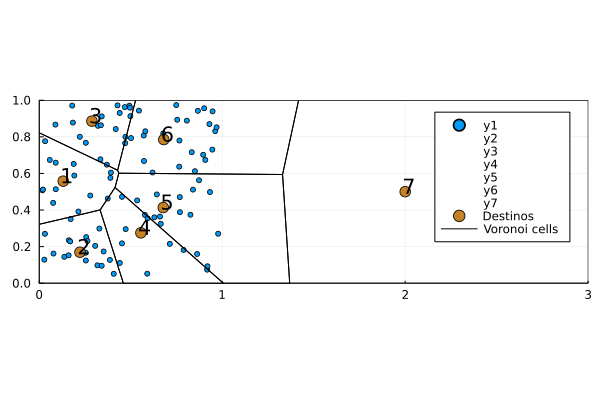

In [32]:
using VoronoiCells
using GeometryBasics
using Plots
using Random

gr()
Plots.GRBackend()

#crea la lista de destinos
points = [Point2(y[i,1], y[i,2]) for i in 1:n] 


#Conjuntos de Voronoi
rect = Rectangle(Point2(0, 0), Point2(3, 1))
tess = voronoicells(points, rect);

scatter(X, Y, aspect_ratio=:equal, markersize = 3, legend = :topright) #Grafica los origenes, con color por destino
scatter!(y[:,1], y[:,2], markersize = 6, label = "Destinos") #Plotea los destinos
annotate!([(points[i][1] + 0.02, points[i][2] + 0.03, text(i, :black)) for i in 1:n]) #Agrega lo números en los destinos
plot!(tess, color = :black)